In [1]:
import torch
from PIL import Image
from glob import glob
import numpy as np
from matplotlib import lines, pyplot as plt
import os
from tqdm.notebook import tqdm
from collections import defaultdict
from torch import nn
from torch import optim
from torch.nn import functional as F
from torchvision.transforms import Compose, Normalize, Resize, InterpolationMode, ToTensor, CenterCrop, ToPILImage
from kornia.geometry.transform import scale, rotate, translate

class BaseRenderer(nn.Module):
    def __init__(self):
        super().__init__()
    def debug(self):
        im = self.forward()
        plt.imshow(im.permute((1,2,0)).cpu().detach())
        plt.axis('off')
        plt.show()
        
device = torch.device("cpu")
np.set_printoptions(precision=4, suppress=True)

im_room = ToTensor()(Image.open('../images/room.png'))
def load_im_mug(mug_size):
    im_mug_tmp = ToTensor()(Image.open('../images/mug.png').resize((mug_size,mug_size)))
    im_mug_tmp = im_mug_tmp[:3,:,:] * im_mug_tmp[-1].unsqueeze(0)
    im_mug = torch.zeros_like(im_room).to(device)
    im_mug[
        :,
        (im_mug.shape[1]-mug_size)//2:(im_mug.shape[1]+mug_size)//2,
        (im_mug.shape[2]-mug_size)//2:(im_mug.shape[2]+mug_size)//2,
    ] = im_mug_tmp
    return im_mug

/Users/lucas/miniforge3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/lucas/miniforge3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: /Users/lucas/miniforge3/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/Users/ec2-user/actions-runner/_work/vision/vision/conda-env-2408739877/lib/libpng16.16.dylib' (no such file), '/Users/ec2-user/actions-runner/_work/vision/vision/conda-env-2408739877/lib/libpng16.16.dylib' (no such file), '/Users/ec2-user/actions-runner/_work/vision/vision/conda-env-2408739877/lib/libpng16.16.dylib' (no such file), '/Users/ec2-user/actions-runner/_work/vision/vision/conda-env-2408739877/lib/libpng16.16.dylib' (no such file), '/Users/lucas/miniforge3/lib/python3.9/lib-dynload/../../libpng16.16.dylib' (no such file), '/Users/lucas/miniforge3/bin/../lib/libpng16.16.dylib' (no such file), '/usr/local/l

In [2]:
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.swa_utils import AveragedModel, update_bn, SWALR

def single_param(s_init, s_target, rc, lr=0.05, n_iterations=50,
                 training_curve=True, zoom_vis=True, im_vis=True,
                 figh=4, suffix="", schedule=None
):
    im_target = rc(s_target)().detach()
    
    loss_name = 'MSE loss'
    loss_fn = lambda im: F.mse_loss(im, im_target)

    losses = defaultdict(list)
    s_values = defaultdict(list)
    for s in s_init:
        renderer = rc(s)
        im_initial = renderer().detach()
        optimizer = optim.Adam(renderer.parameters(), lr=lr)
        if schedule is not None:
            scheduler = MultiStepLR(optimizer, **schedule)
            lr_steps = []
        else:
            scheduler = None
            
    
        epochs = np.arange(n_iterations)
        for epoch in epochs:
            optimizer.zero_grad()
            im = renderer()
            loss = loss_fn(im)
            losses[s].append(loss.item())
            s_values[s].append(renderer.s.detach().cpu().item())
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                lr_steps.append(scheduler.get_last_lr())
                scheduler.step()

        losses[s].append(loss.item())
        s_values[s].append(renderer.s.detach().cpu().item())

        # gradient descent graph
        if training_curve:
            fig = plt.figure(figsize=(10,8))
            plt.suptitle('initial s = %.2f' % s)
            plt.subplot(2,3,1)
            plt.title('Initial image\n(s = %.2f)' % s)
            plt.imshow(im_initial.permute((1,2,0)))
            plt.axis('off')
            plt.subplot(2,3,2)
            plt.title('Target image\n(s = %.2f)' % s_target)
            plt.imshow(im_target.permute((1,2,0)))
            plt.axis('off')
            plt.subplot(2,3,3)
            plt.title('Gradient descent solution\n(s = %.4f)' % renderer.s.detach().item())
            plt.imshow(im.detach().permute((1,2,0)))
            plt.axis('off')

            plt.subplot(2,1,2)
            L = []
            L += plt.plot(losses[s], 'o-', label='MSE loss')
            plt.ylabel('MSE loss')
            plt.ylim(0, max(losses[s]))
            plt.xlabel('Iteration')
            ax = plt.gca().twinx()
            L += ax.plot(s_values[s], 'o-', label='s value', color='orange')
            ax.legend(L, [l.get_label() for l in L])
            ax.set_ylabel('s value')

            plt.suptitle('Single parameter: %s' % renderer.description)
            plt.tight_layout()
            #plt.savefig('figs/mse-optimization.pdf', bbox_inches='tight')
            plt.show()
    S_colors = dict(zip(s_init, ['orange', 'red', 'yellow']))
    # loss landscape
    S = np.concatenate((
        np.linspace(-3,3,100),
        [*s_init, s_target]
    ))
    S.sort()
    with torch.no_grad():
        all_losses = [loss_fn(rc(s)()).item() for s in S]

    row_count = 1+int(zoom_vis)+int(im_vis)
    fig = plt.figure(figsize=(14,figh*row_count))
    plt.subplot(row_count,1,1)
    plt.title('Mug %s (lr = %.3f)\n' % (renderer.description, lr) + r'($s_{target}$ = %.2f)' % (s_target))
    plt.plot(S, all_losses, 'o-')
    plt.xlabel ('s (%s)' % renderer.description)
    plt.ylabel(loss_name)
    ax = plt.gca()
    for k in s_values.keys():
        color = S_colors[k]
        with torch.no_grad():
            plt.plot(k, loss_fn(rc(k)()).item(), marker='s', ms=12, color=color)
        plt.plot(s_values[k], losses[k], label='initial s = %.2f' % k, lw=2, color=color)
        plt.plot(s_values[k][-1], losses[k][-1], marker='o', ms=12, color=color)
        
    plt.legend()
    
    ax_zoom = {}
    if zoom_vis:
        for i,k in enumerate(s_values.keys()):
            color = S_colors[k]
            plt.subplot(row_count,len(s_init),len(s_init)+i+1)
            s_to_zoom_around = s_values[k][-1]
            S_zoom = np.concatenate((
                np.linspace(s_to_zoom_around-0.1,s_to_zoom_around+0.1,100),
                [s_to_zoom_around]
            ))
            S_zoom.sort()
            with torch.no_grad():
                zoomed_losses = [loss_fn(rc(s)()).item() for s in S_zoom]
            plt.plot(S_zoom, zoomed_losses, 'o-')
            plt.plot(s_values[k], losses[k], label='initial s = %.2f' % k, lw=2, color=color)
            plt.plot(k, loss_fn(rc(k)()).detach().item(), marker='s', ms=12, color=color)
            plt.plot(s_values[k][-1], losses[k][-1], marker='o', ms=12, color=color)
            plt.xlim(min(S_zoom), max(S_zoom))
            plt.ylim(min(zoomed_losses)*0.98, max(zoomed_losses)*1.02)
            plt.xlabel('s (%s)' % renderer.description)
            plt.title('Zoomed around s=%.2f' % s_values[k][-1])
            plt.ylabel(loss_name)
            ax_zoom[s_values[k][-1]] = plt.gca()
    
    if im_vis:
        sol_s_vals = [(s_values[k][-1], losses[k][-1]) for k in s_values.keys()]
        sol_s_vals.insert(len(s_values)//2, (s_target, 0.0))
        for i,(sol_s_val, sol_loss_val) in enumerate(sol_s_vals):
            plt.subplot(3,len(sol_s_vals), 2*len(sol_s_vals) +i+1)
            im_sol = rc(sol_s_val)().detach().permute((1,2,0))
            plt.imshow(im_sol)
            plt.axis('off')
            if sol_s_val == s_target:
                plt.title('s = %.2f (target)' % sol_s_val)
            else:
                plt.title('s = %.2f' % sol_s_val)
                if zoom_vis:
                    ax_im = plt.gca()
                    
                    transFigure = fig.transFigure.inverted()
                    coord1 = transFigure.transform(ax_zoom[sol_s_val].transData.transform([sol_s_val, sol_loss_val]))
                    coord2 = transFigure.transform(ax_im.transData.transform([im_sol.shape[1]/2, 0]))
                    line = lines.Line2D(
                        (coord1[0], coord2[0]),  # xdata
                        (coord1[1], coord2[1]),  # ydata
                        transform=fig.transFigure,
                        color="grey",
                        zorder=1
                    )
                    fig.lines.append(line)
    
    #plt.tight_layout()
    if loss_name != 'MSE loss':
        plt.savefig('figs/3_1-mse-gd-%s-%s-optimization%s.pdf' % (loss_name, renderer.description, suffix), bbox_inches='tight')
    else:
        plt.savefig('figs/3_1-mse-gd-%s-optimization%s.pdf' % (renderer.description, suffix), bbox_inches='tight')
    plt.show()
    
    if scheduler is not None:
        plt.plot(epochs, lr_steps, 'o-')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()

# One parameter: rotation

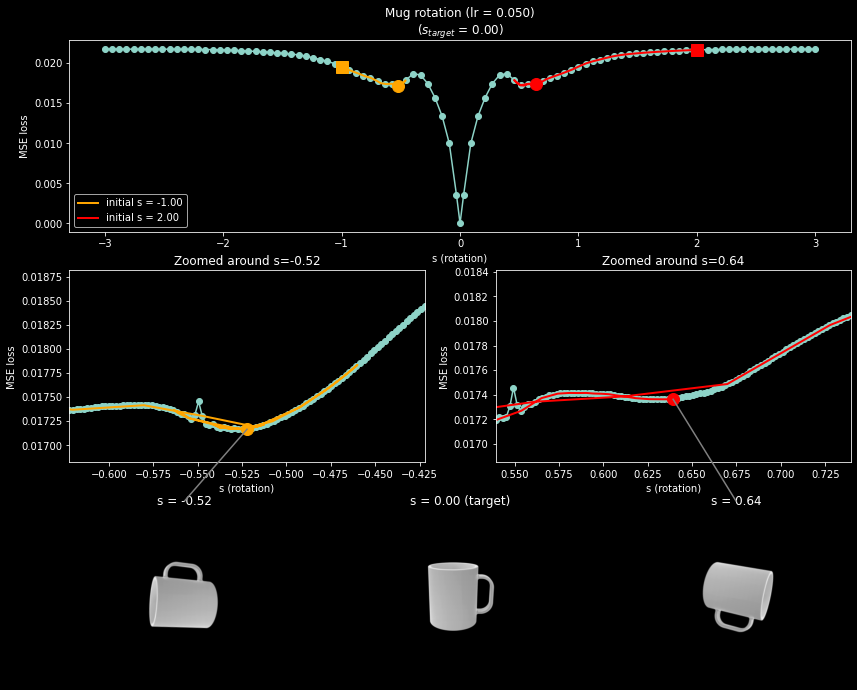

In [4]:
mug_size_rotation = 150
im_mug_rotation = load_im_mug(mug_size_rotation)

class MugMoidRotate(BaseRenderer):
    def __init__(self, s=0):
        super().__init__()
        self.s = nn.Parameter(torch.Tensor([s]))
        self.description = 'rotation'

    def forward(self):
        room = im_room.clone()
        mug = im_mug_rotation.unsqueeze(0)
        mug = rotate(mug, -self.s.tanh()*180)
        mug = mug.squeeze()
        return mug
    
single_param(s_init=[-1,2], s_target=0, rc=MugMoidRotate, training_curve=False, zoom_vis=True, im_vis=True)

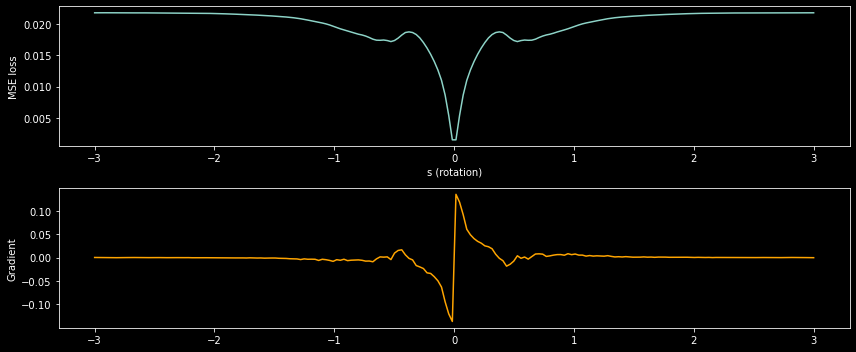

In [6]:
rc = MugMoidRotate
S = np.linspace(-3,3,200)

im_target = rc(0.0)().detach()

gradients = []
losses = []
for s in S:
    renderer = rc(s)
    im = renderer()
    loss = F.mse_loss(im, im_target)
    loss.backward()
    losses.append(loss.detach().item())
    gradients.append(renderer.s.grad.detach().item())
    
fig = plt.figure(figsize=(12,5))

plt.subplot(2,1,1)
plt.plot(S, losses, label='loss')
plt.xlabel('s (%s)' % renderer.description)
plt.ylabel('MSE loss')

plt.subplot(2,1,2)
#plt.gca().twinx()
plt.plot(S, gradients, label='gradients', color='orange')
plt.ylabel('Gradient')
#plt.legend()
plt.tight_layout()
plt.show()

# One parameter: scale

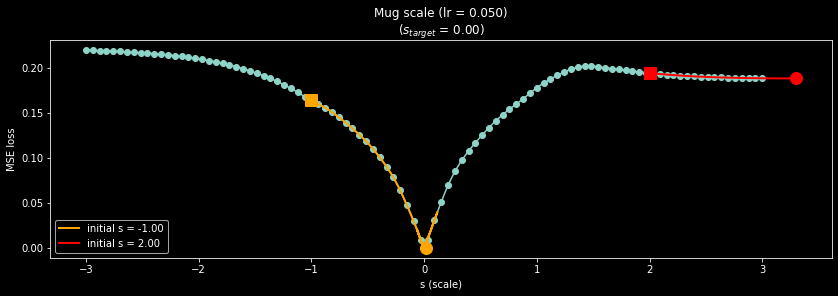

In [7]:
mug_size_scale = 350
im_mug_scale = load_im_mug(mug_size_scale)

class MugMoidScale(BaseRenderer):
    def __init__(self, s=0):
        super().__init__()
        self.s = nn.Parameter(torch.Tensor([s]))
        self.description = 'scale'

    def forward(self):
        return scale(
            im_mug_scale.unsqueeze(0),
            2*self.s.sigmoid().unsqueeze(0)
        ).squeeze()

single_param(s_init=[-1,2], s_target=0, rc=MugMoidScale, training_curve=False, zoom_vis=False, im_vis=False)

# One parameter: x-translation

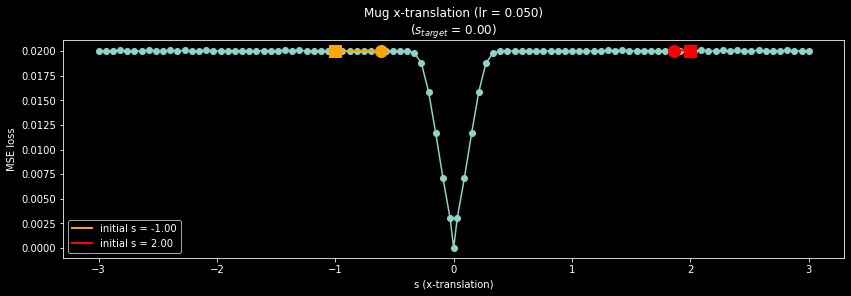

In [8]:
mug_size_tx = 75
im_mug_tx = load_im_mug(mug_size_tx)
    
class MugMoidTranslate(BaseRenderer):
    def __init__(self, s=0):
        super().__init__()
        self.s = nn.Parameter(torch.Tensor([s]))
        self.description = 'x-translation'

    def forward(self):
        room = im_room.clone()
        mug = im_mug_tx.unsqueeze(0)
        translation = torch.cat((
            (im_mug_tx.shape[2]-mug_size_tx)*0.5*self.s.tanh(),
             torch.tensor([0])
        )).unsqueeze(0)
        mug = translate(mug, translation)
        mug = mug.squeeze()
        return mug
        room[mug > 0] = mug[mug > 0]
        return room
single_param(s_init=[-1,2], s_target=0, rc=MugMoidTranslate, training_curve=False, zoom_vis=False, im_vis=False)

# LR tweaking

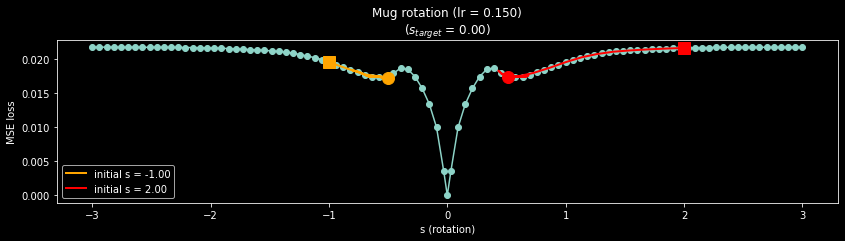

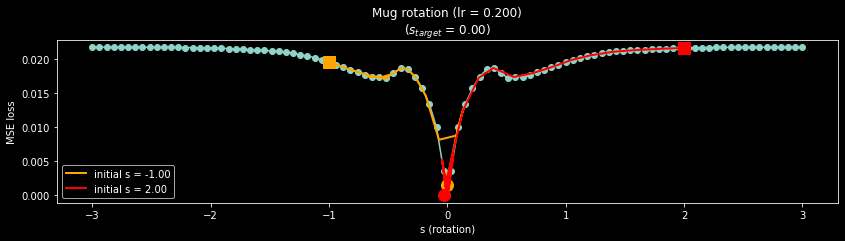

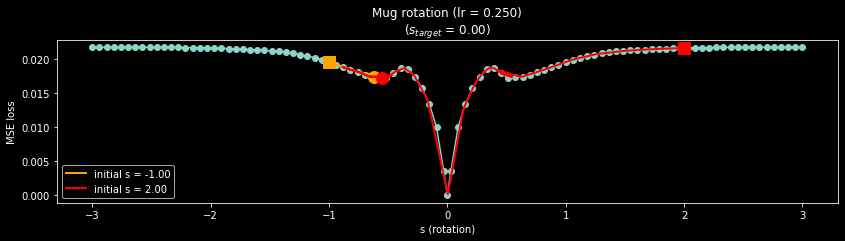

In [19]:
for lr in [0.15, 0.20, 0.25]:
    single_param(s_init=[-1,2], s_target=0, rc=MugMoidRotate, lr=lr, suffix="-lr%.2f"%lr, figh=3, training_curve=False, zoom_vis=False, im_vis=False)


# Annealing

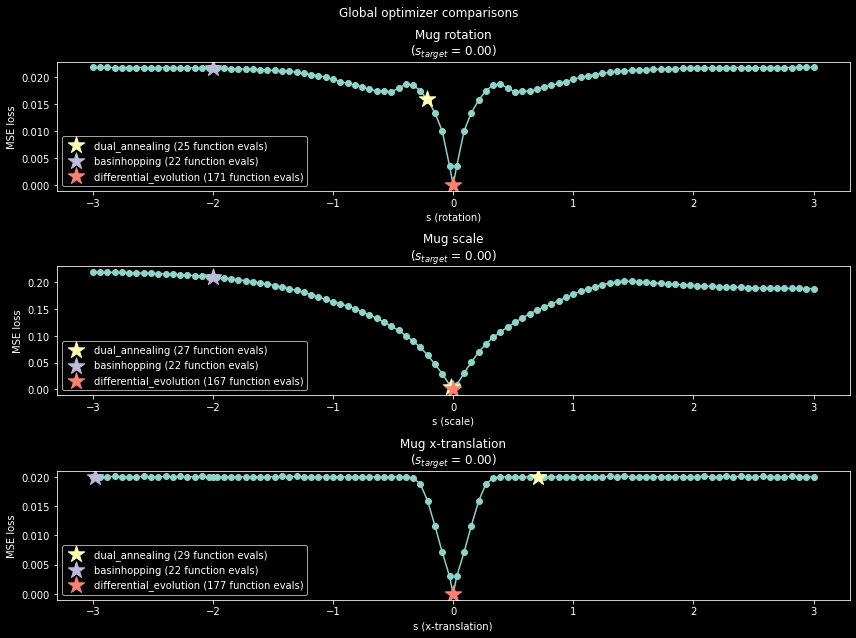

In [22]:
from scipy.optimize import dual_annealing, basinhopping, differential_evolution
def optimize(s_init, s_target, rc, maxiter, minimizer_maxiter):    
    im_target = rc(s_target)().detach()

    def call_counter(func):
        def helper(*args, **kwargs):
            helper.calls += 1
            return func(*args, **kwargs)
        helper.calls = 0
        return helper
    
    @call_counter
    def loss_fn(s):
        im = rc(*s)()
        return F.mse_loss(im_target, im)
    
    S = np.concatenate((np.linspace(-3,3,100), [s_init, s_target]))
    S.sort()
    with torch.no_grad():
        all_losses = [loss_fn([s]) for s in S] 
        results = {}
        evals = {}
        im_target = rc(s_target)()
        
        loss_fn.calls = 0
        results['dual_annealing'] = dual_annealing(
            loss_fn,
            bounds=[(-3,3)],
            minimizer_kwargs={'options': {'maxiter': minimizer_maxiter}},
            maxiter=maxiter,
            seed=1337
        )
        evals['dual_annealing'] = loss_fn.calls

        loss_fn.calls = 0
        results['basinhopping'] = basinhopping(loss_fn, s_init, niter=maxiter, seed=1337)
        evals['basinhopping'] = loss_fn.calls

        loss_fn.calls = 0
        results['differential_evolution'] = differential_evolution(loss_fn, bounds=[(-3,3)], maxiter=maxiter, seed=1337)
        evals['differential_evolution'] = loss_fn.calls
        
    #plt.figure(figsize=(12,4))
    plt.plot(S, all_losses, 'o-', zorder=1)
    ax = plt.gca()
    for k,result in results.items():
        color = next(ax._get_lines.prop_cycler)['color']
        plt.scatter(result.x[0], result.fun, marker='*', s=300, label='%s (%d function evals)' % (k, evals[k]), c=color, zorder=2)
    plt.legend()
    plt.title('Mug %s\n' % rc().description + r'($s_{target}$ = %.2f)' % (s_target))
    plt.xlabel('s (%s)' % rc().description)
    plt.ylabel('MSE loss')
    #plt.show()

maxiter = 10
plt.figure(figsize=(12,9))
plt.subplot(3,1,1)
optimize(s_init=-2, s_target=0, rc=MugMoidRotate, maxiter=maxiter, minimizer_maxiter=30)
plt.subplot(3,1,2)
optimize(s_init=-2, s_target=0, rc=MugMoidScale, maxiter=maxiter, minimizer_maxiter=30)
plt.subplot(3,1,3)
optimize(s_init=-2, s_target=0, rc=MugMoidTranslate, maxiter=maxiter, minimizer_maxiter=30)

plt.suptitle('Global optimizer comparisons')
plt.tight_layout()
plt.savefig('figs/3_1-global-optimizers.pdf', bbox_inches='tight')
plt.show()

# Extra figures

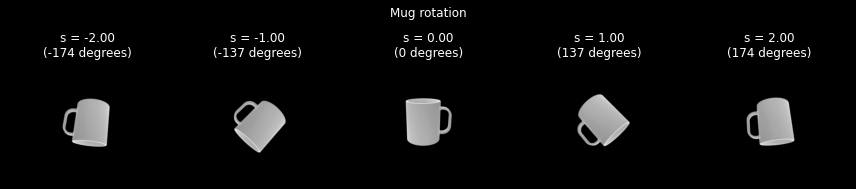

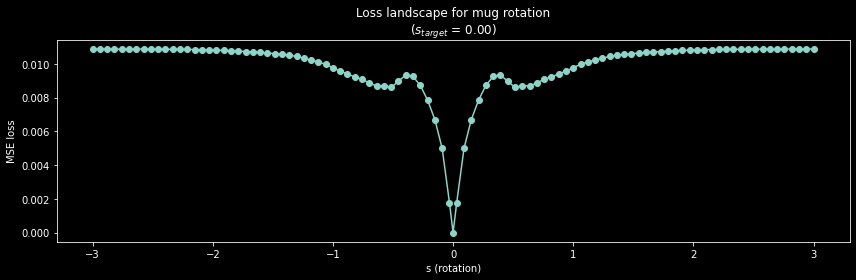

In [23]:
fig = plt.figure(figsize=(12,3))
s_vals = np.linspace(-2,2,5)
for i,s in enumerate(s_vals):
    plt.subplot(1,len(s_vals),i+1)
    plt.imshow(MugMoidRotate(s)().detach().permute((1,2,0)))
    plt.title('s = %.2f\n(%.0f degrees)' % (s, np.tanh(s)*180))
    plt.axis('off')
plt.suptitle('Mug rotation')
plt.tight_layout()
plt.savefig('figs/3_1-rotations.pdf', bbox_inches='tight')
plt.show()

rc = MugMoidRotate
with torch.no_grad():
    s_target = 0
    im_target = rc(s_target)()
    loss_fn = lambda s: F.huber_loss(rc(s)(), im_target)
    S = np.concatenate((np.linspace(-3,3,100), [s_target]))
    S.sort()
    all_losses = [loss_fn(s) for s in S] 

fig = plt.figure(figsize=(12,4))
plt.plot(S, all_losses, 'o-')
plt.xlabel('s (rotation)')
plt.ylabel('MSE loss')
plt.title('Loss landscape for mug rotation\n' + r'($s_{target}$ = %.2f)' % s_target)
plt.tight_layout()
plt.savefig('figs/3_1-rotation-landscape.pdf', bbox_inches='tight')
plt.show()

# Two parameters: scale/rotation

  0%|          | 0/250 [00:00<?, ?it/s]

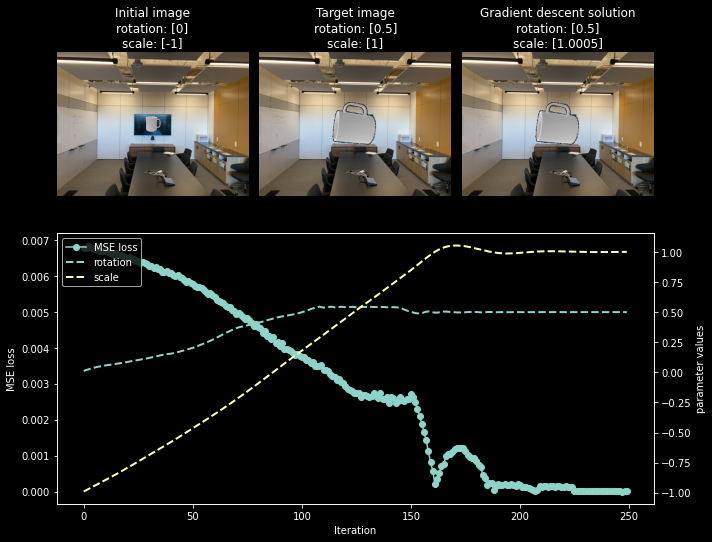

In [24]:
im_room = ToTensor()(Image.open('../images/room.png')).to(device)
im_room = scale(
    im_room.unsqueeze(0),
    torch.tensor([1.0]).to(device),
    center=torch.tensor([[float(im_room.shape[2] // 2), (im_room.shape[1] // 2)+100.0]]).to(device)
).squeeze()

mug_size = 150
im_mug_tmp = ToTensor()(Image.open('../images/mug.png').resize((mug_size,mug_size)))
im_mug_tmp = im_mug_tmp[:3,:,:] * im_mug_tmp[-1].unsqueeze(0)
im_mug = torch.zeros_like(im_room).to(device)
im_mug[
       :,
       im_mug.shape[1]//2-mug_size//2:im_mug.shape[1]//2+mug_size//2,
       im_mug.shape[2]//2-mug_size//2:im_mug.shape[2]//2+mug_size//2
] = im_mug_tmp

class RoomRenderer(BaseRenderer):
    def __init__(self, scale=0, rotation=0):
        super().__init__()
        self.params = nn.ParameterDict({
           'scale': nn.Parameter(torch.Tensor([scale]), requires_grad=True),
           'rotation': nn.Parameter(torch.Tensor([rotation]), requires_grad=True)
        })

        height,width = im_room.shape[1:]
        self.uv = torch.tensor([width,height], device=device) / 2 - mug_size/2

    def forward(self):
        room = im_room.clone()

        mug = im_mug.unsqueeze(0)
        mug = scale(mug, self.params['scale'].sigmoid())
        mug = rotate(mug, self.params['rotation'].tanh() * 180)        
        mug = mug.squeeze()
        room[mug > 0] = mug[mug > 0]
        return room

from collections import defaultdict

s_init = {'rotation': 0, 'scale': -1}
s_target = {'rotation': 0.5, 'scale': 1}

rc = RoomRenderer

im_target = rc(**s_target)().detach()

lr = 0.01

renderer = rc(**s_init)
im_initial = renderer().detach()
optimizer = optim.Adam(renderer.parameters(), lr=lr)

epochs = np.arange(250)
t = tqdm(epochs)

losses = []
param_values = defaultdict(list)
for epoch in t:
    optimizer.zero_grad()
    im = renderer()
    
    loss = F.mse_loss(im_target, im)
    loss.backward()
    optimizer.step()
    
    # update info
    t.set_description(
        'mse=%.5f' % (loss.item()),
        refresh=True
    )
    
    losses.append(loss.item())
    for k,v in renderer.params.items():
        param_values[k].append(v.detach().clone().numpy())
param_values_stacked = {
    k: np.vstack(v)
    for k,v in param_values.items()
}

fig = plt.figure(figsize=(10,8))
plt.subplot(2,3,1)
plt.title('Initial image\n%s' % '\n'.join('%s: %s' % (k,np.atleast_1d(v)) for k,v in s_init.items()))
plt.imshow(im_initial.permute((1,2,0)))
plt.axis('off')
plt.subplot(2,3,2)
plt.title('Target image\n%s' % '\n'.join('%s: %s' % (k,np.atleast_1d(v)) for k,v in s_target.items()))
plt.imshow(im_target.permute((1,2,0)))
plt.axis('off')
plt.subplot(2,3,3)
plt.title('Gradient descent solution\n%s' % '\n'.join('%s: %s' % (k,v.detach().numpy()) for k,v in renderer.params.items()))
plt.imshow(im.detach().permute((1,2,0)))
plt.axis('off')

plt.subplot(2,1,2)
lines = []

lines += plt.plot(epochs, losses, 'o-', label='MSE loss')
plt.ylabel('MSE loss')
#plt.ylim(0, max(losses))
plt.xlabel('Iteration')

ax = plt.gca().twinx()

for k,vals in param_values_stacked.items():
    if vals.shape[1] > 1:
        for v,k_extra in zip(vals.T, [' (x)', '(y)']):
            lines += ax.plot(epochs, v, '--', label=k+k_extra, lw=2)
    else:
        lines += ax.plot(epochs, vals, '--', label=k, lw=2)
ax.legend(lines, [l.get_label() for l in lines])
ax.set_ylabel('parameter values')

plt.tight_layout()
plt.savefig('figs/multiparam-mse-optimization.pdf', bbox_inches='tight')
plt.show()

# Two parameters: x,y-translation

In [14]:
# room img
im_room = ToTensor()(Image.open('../images/room.png')).to(device)
im_room = scale(
    im_room.unsqueeze(0),
    torch.tensor([1.0]).to(device),
    center=torch.tensor([[float(im_room.shape[2] // 2), (im_room.shape[1] // 2)+100.0]]).to(device)
).squeeze()

mug_size = 150
im_mug_tmp = ToTensor()(Image.open('../images/mug.png').resize((mug_size,mug_size)))
im_mug_tmp = im_mug_tmp[:3,:,:] * im_mug_tmp[-1].unsqueeze(0)
im_mug = torch.zeros_like(im_room).to(device)
im_mug[
       :,
       im_mug.shape[1]//2-mug_size//2:im_mug.shape[1]//2+mug_size//2,
       im_mug.shape[2]//2-mug_size//2:im_mug.shape[2]//2+mug_size//2
] = im_mug_tmp


class RoomRenderer(BaseRenderer):
    def __init__(self, tx=0, ty=0, scale=0, rotation=0, translation=(0.0, 0.0)):
        super().__init__()
        self.params = nn.ParameterDict({
#            'tx': nn.Parameter(torch.Tensor([tx]), requires_grad=False),
#            'ty': nn.Parameter(torch.Tensor([ty]), requires_grad=False),
            'translation': nn.Parameter(torch.Tensor(translation), requires_grad=True),
#            'scale': nn.Parameter(torch.Tensor([scale]), requires_grad=True),
#            'rotation': nn.Parameter(torch.Tensor([rotation]), requires_grad=True)
        })

        height,width = im_room.shape[1:]
        self.uv = torch.tensor([width,height], device=device) / 2 - mug_size/2

    def forward(self):
        room = im_room.clone()

        mug = im_mug.unsqueeze(0)
        #mug = scale(mug, self.params['scale'].sigmoid())
        #mug = rotate(mug, self.params['rotation'].tanh() * 180)

        mug = translate(mug, self.uv*self.params['translation'].tanh().unsqueeze(0)).squeeze()
        
        #mug = translate(
        #    mug,
        #    #torch.tensor([[250*self.params['tx'], 150*self.params['ty']]], requires_grad=True)
        #    self.uv*self.params['translation'].unsqueeze(0)
        #) # .tanh().unsqueeze(0)).squeeze()
        
        mug = mug.squeeze()
        return mug

        room[mug > 0] = mug[mug > 0]
        return room

#RoomRenderer(translation=(-100,0)).debug()
#RoomRenderer(tx=-0.5).debug()
#RoomRenderer(tx=0.5).debug()

In [15]:
from collections import defaultdict

#s_init = {'rotation': 0, 'scale': -1, 'tx': 0, 'ty': 0}
#s_target = {'rotation': 0.5, 'scale': 1, 'tx': 0, 'ty': 0}

s_init = {'translation': (-0.5, 0)}
s_target = {'translation': (0.5, 0)}

rc = RoomRenderer

im_target = rc(**s_target)().detach()

lr = 0.01

renderer = rc(**s_init)
im_initial = renderer().detach()
optimizer = optim.Adam(renderer.parameters(), lr=lr)

epochs = np.arange(250)
t = tqdm(epochs)

losses = []
param_values = defaultdict(list)



for epoch in t:
    optimizer.zero_grad()
    im = renderer()
    
    loss = F.mse_loss(im_target, im)
    #loss = -loss_fn(im, im_target)
    loss.backward()
    #print(renderer.params['rotation'].grad)
    optimizer.step()
    
    # update info
    t.set_description(
        'mse=%.5f' % (loss.item()),
        refresh=True
    )
    
    losses.append(loss.item())
    for k,v in renderer.params.items():
        param_values[k].append(v.detach().clone().numpy())
    

  0%|          | 0/250 [00:00<?, ?it/s]

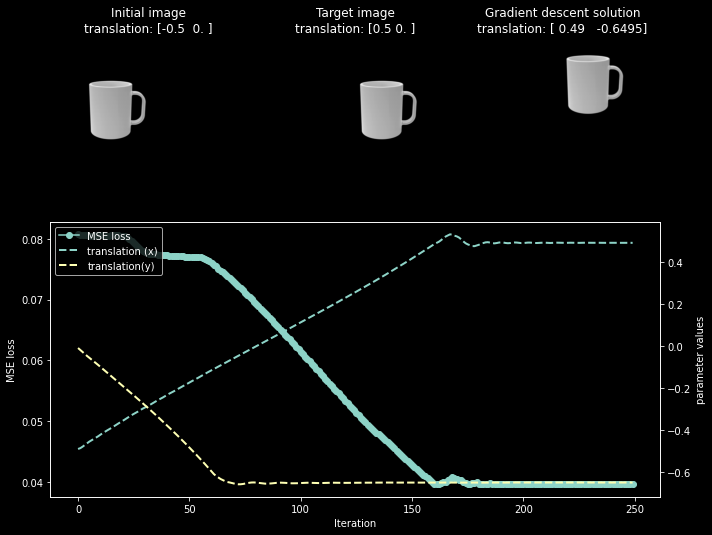

In [16]:
param_values_stacked = {
    k: np.vstack(v)
    for k,v in param_values.items()
}

fig = plt.figure(figsize=(10,8))

plt.subplot(2,3,1)
plt.title('Initial image\n%s' % '\n'.join('%s: %s' % (k,np.atleast_1d(v)) for k,v in s_init.items()))
plt.imshow(im_initial.permute((1,2,0)))
plt.axis('off')

plt.subplot(2,3,2)
plt.title('Target image\n%s' % '\n'.join('%s: %s' % (k,np.atleast_1d(v)) for k,v in s_target.items()))
plt.imshow(im_target.permute((1,2,0)))
plt.axis('off')

plt.subplot(2,3,3)
plt.title('Gradient descent solution\n%s' % '\n'.join('%s: %s' % (k,v.detach().numpy()) for k,v in renderer.params.items()))
plt.imshow(im.detach().permute((1,2,0)))
plt.axis('off')


plt.subplot(2,1,2)
lines = []

lines += plt.plot(epochs, losses, 'o-', label='MSE loss')
plt.ylabel('MSE loss')
#plt.ylim(0, max(losses))
plt.xlabel('Iteration')

ax = plt.gca().twinx()

for k,vals in param_values_stacked.items():
    if vals.shape[1] > 1:
        for v,k_extra in zip(vals.T, [' (x)', '(y)']):
            lines += ax.plot(epochs, v, '--', label=k+k_extra, lw=2)
    else:
        lines += ax.plot(epochs, vals, '--', label=k, lw=2)
ax.legend(lines, [l.get_label() for l in lines])
ax.set_ylabel('parameter values')

        
        
plt.tight_layout()
plt.savefig('figs/multiparam-mse-optimization.pdf', bbox_inches='tight')
plt.show()

# 3D loss landscapes

In [17]:
#plt.figure(figsize=(6,4))
X = np.linspace(-1, 1, 100)
Y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(X, Y)

im_target = rc(translation=[0,0])().detach()

@np.vectorize
def calc_loss(x,y):
    with torch.no_grad():
        return F.mse_loss(
            im_target, rc(translation=[x,y])()
        )
Z = calc_loss(X,Y)


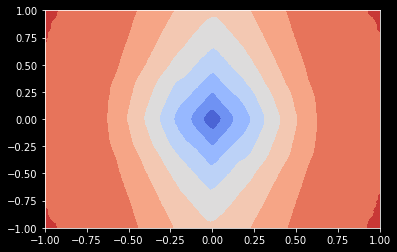

In [18]:
from matplotlib import cm

#fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.contourf(X, Y, Z, cmap=cm.coolwarm)
plt.show()